<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a gpu?
!nvidia-smi

Fri Jun 10 06:18:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-06-10 06:18:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.251.6.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   267MB/s    in 0.6s    

2022-06-10 06:18:42 (267 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

## Creating data loaders (preparing the data)

We'll use the `image_dataset_from_directory` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

IMAGE_SHAPE = (224, 224)
BATCH_SIZE =32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

rescale = Rescaling(1/255.)

print('Training images:')
train_data_10_percent = image_dataset_from_directory(train_dir,
                                                     label_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMAGE_SHAPE,
                                                     seed=42)
train_data_10_percent = train_data_10_percent.map(lambda x, y: (rescale(x), y))
print('Testing images:')
test_data = image_dataset_from_directory(test_dir,
                                         label_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)
test_data = test_data.map(lambda x, y: (rescale(x), y))

Training images:
Found 750 files belonging to 10 classes.
Testing images:
Found 2500 files belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorFlow callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models in: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np

In [8]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [9]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor 
        layer and Dense output layer with num_classes output neurons.
    """

    # Download the pretrain model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [10]:
# Extracting labels in MapDataset
labels = np.array([])
for x, y in train_data_10_percent:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
labels_count = max(labels) + 1
labels_count

10.0

In [11]:
# Creating ResNet Model
resnet_model = create_model(resnet_url,
                            num_classes=labels_count)

In [12]:
# Compile our ResNet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
# Fit ResNet model
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")],
                                  validation_steps=len(test_data))

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220610-061857
Epoch 1/5
24/24 [==============================] - 26s 459ms/step - loss: 1.8535 - accuracy: 0.3853 - val_loss: 1.1764 - val_accuracy: 0.6144
Epoch 2/5
24/24 [==============================] - 13s 534ms/step - loss: 0.8577 - accuracy: 0.7453 - val_loss: 0.8578 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 10s 396ms/step - loss: 0.5856 - accuracy: 0.8307 - val_loss: 0.7377 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 13s 533ms/step - loss: 0.4410 - accuracy: 0.8840 - val_loss: 0.7105 - val_accuracy: 0.7636
Epoch 5/5
24/24 [==============================] - 10s 406ms/step - loss: 0.3594 - accuracy: 0.9173 - val_loss: 0.6778 - val_accuracy: 0.7752


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [17]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validaton and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for trainng and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

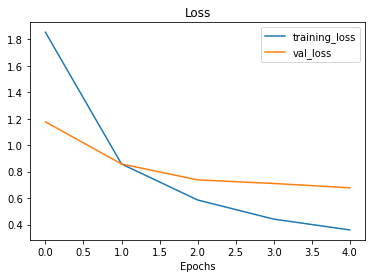

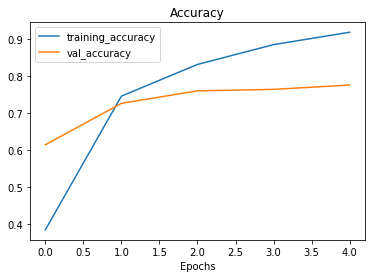

In [18]:
plot_loss_curves(history_resnet)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [19]:
# Creating EfficientNetB0 model
efficient_net_model = create_model(efficientnet_url,
                                   num_classes=labels_count)

In [20]:
# Compiling EfficientNetB0 model
efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

In [21]:
from gc import callbacks
# Fit EfficientNetB0 model
history_efficient_net = efficient_net_model.fit(train_data_10_percent,
                                                epochs=5,
                                                steps_per_epoch=len(train_data_10_percent),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                       experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220610-063610
Epoch 1/5
24/24 [==============================] - 19s 382ms/step - loss: 1.8757 - accuracy: 0.4067 - val_loss: 1.2926 - val_accuracy: 0.7200
Epoch 2/5
24/24 [==============================] - 8s 315ms/step - loss: 1.0739 - accuracy: 0.7667 - val_loss: 0.8643 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 9s 364ms/step - loss: 0.7605 - accuracy: 0.8347 - val_loss: 0.6906 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 12s 515ms/step - loss: 0.6129 - accuracy: 0.8613 - val_loss: 0.6037 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 8s 310ms/step - loss: 0.5163 - accuracy: 0.8827 - val_loss: 0.5516 - val_accuracy: 0.8636


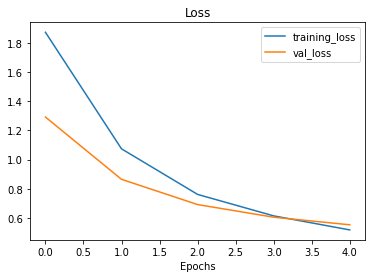

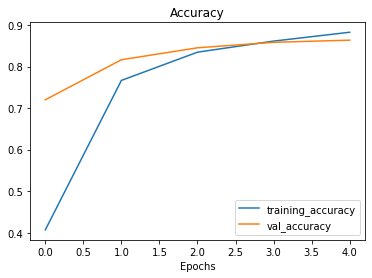

In [22]:
# Plot the loss curves
plot_loss_curves(history_efficient_net)

In [23]:
# EfficientNetB0 model summary
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [29]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficient_net_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [30]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=u6UzqVszfqEuN4skLbPrDmvn30j2TB&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publicly here: https://tensorboard.dev/experiment/l6iGFxMYSYypZb9tp2TOkg/

In [31]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/l6iGFxMYSYypZb9tp2TOkg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   l6iGFxMYSYypZb9tp2TOkg
	Created              2022-06-10 07:07:57 (3 minutes ago)
	Updated              2022-06-10 07:07:59 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794877
Total: 1 experiment(s)


In [32]:
# Delete an experiment
# !tensorboard dev delete --experiment_id l6iGFxMYSYypZb9tp2TOkg

In [33]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/l6iGFxMYSYypZb9tp2TOkg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   l6iGFxMYSYypZb9tp2TOkg
	Created              2022-06-10 07:07:57 (6 minutes ago)
	Updated              2022-06-10 07:07:59 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794877
Total: 1 experiment(s)
